In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow
import statsmodels.api as sm

import brasa

In [2]:
df = brasa.get_dataset("b3-futures-dol-first-generic").to_table().to_pandas()

In [3]:
df_dol = brasa.get_dataset("bcb-currency-data").filter(pc.field("symbol") == "BRLUSD").scanner(columns=["refdate", "close"]).to_table().to_pandas()
# df_dol = df_dol.set_index("refdate").shift(1).reset_index()

<Axes: xlabel='refdate'>

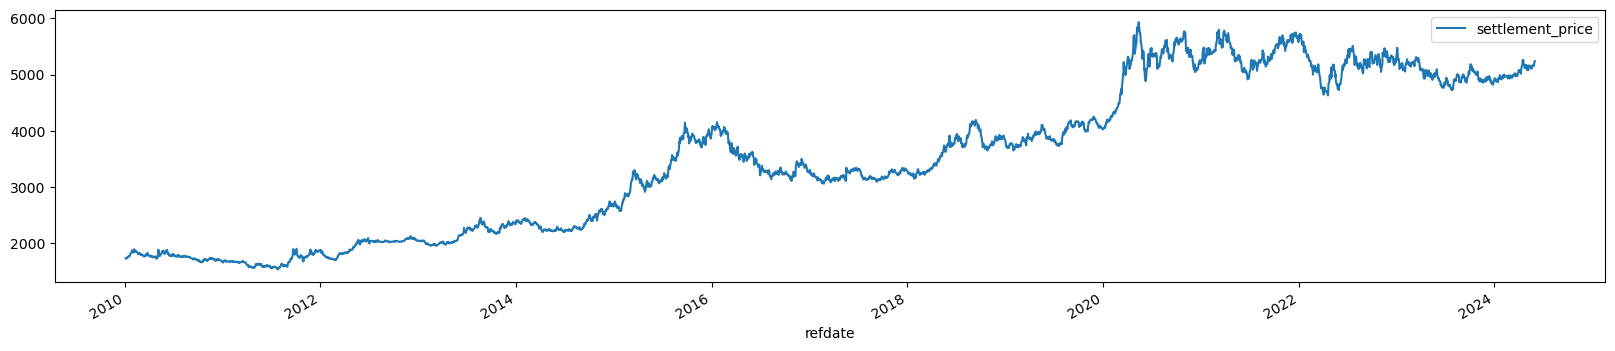

In [4]:
df.plot(x="refdate", y="settlement_price", figsize=(20, 4))

In [5]:
df_cur = (
    df[["refdate", "settlement_price", "ref"]]
        .merge(df_dol, on="refdate", how="left")
        .rename(columns={"settlement_price": "FUT", "close": "SPOT"})
        .set_index("refdate")
        .assign(
            SPOT=lambda df: 1 / df.SPOT,
            FUT=lambda df: df.FUT / 1000,
            DIF=lambda df: df.FUT - df.SPOT
        )
)

<Axes: xlabel='refdate'>

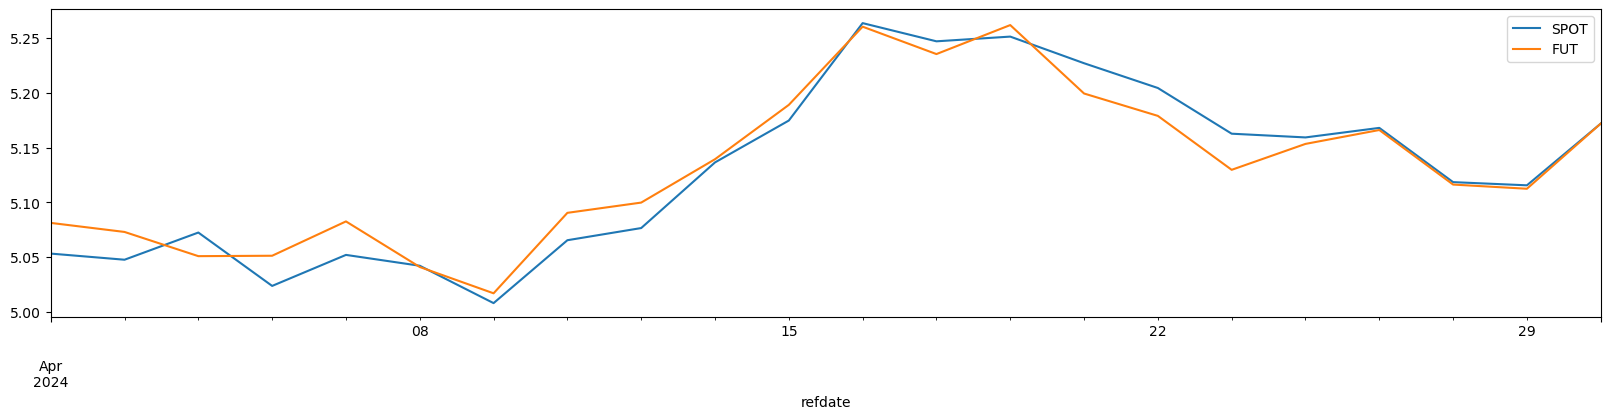

In [6]:
df_cur.query("refdate.dt.year == 2024 and refdate.dt.month == 4")[["SPOT", "FUT"]].plot(figsize=(20, 4))

<Axes: xlabel='refdate'>

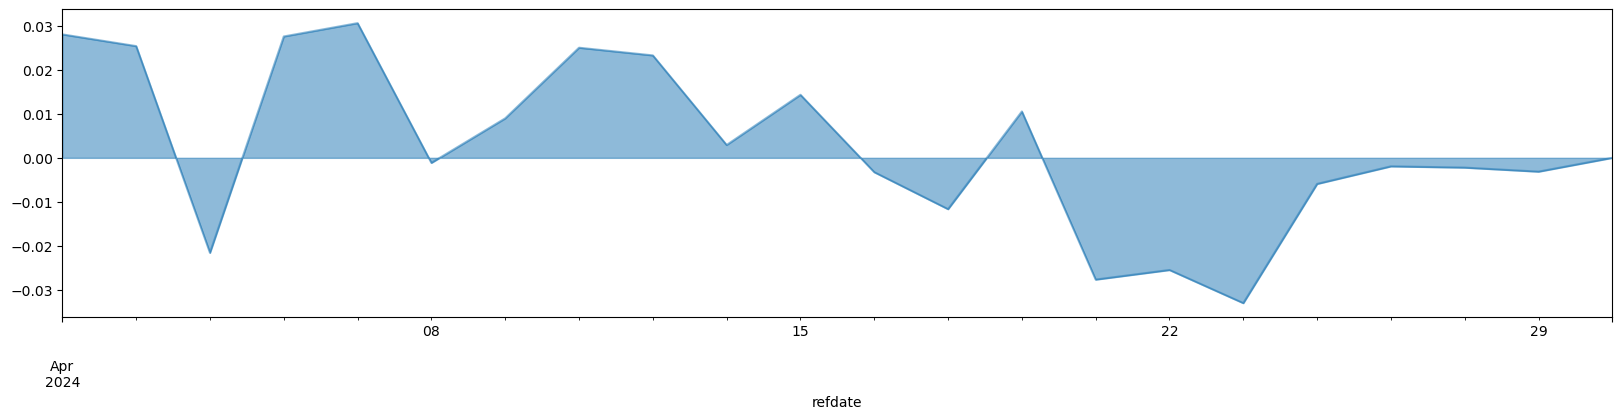

In [7]:
df_cur.query("refdate.dt.year == 2024 and refdate.dt.month == 4").DIF.plot.area(figsize=(20, 4), stacked=False)

In [8]:
df_win = brasa.get_dataset("b3-futures-win-first-generic").to_table().to_pandas()
df_ind = brasa.get_dataset("brasa-prices").filter(pc.field("symbol") == "IBOV").scanner(columns=["refdate", "close"]).to_table().to_pandas()

In [9]:
df_fut_ind = (
    df_win[["refdate", "settlement_price", "ref"]]
        .merge(df_ind, on="refdate", how="left")
        .rename(columns={"settlement_price": "FUT", "close": "SPOT"})
        .set_index("refdate")
        .assign(
            DIF=lambda df: df.FUT - df.SPOT
        )
)

<Axes: xlabel='refdate'>

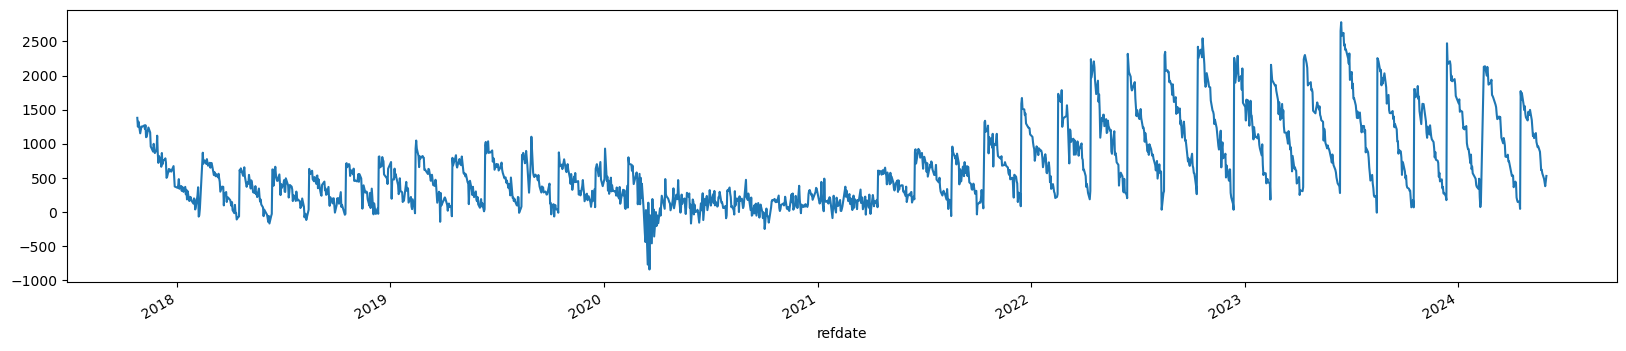

In [10]:
df_fut_ind.DIF.plot(figsize=(20, 4))

In [11]:
df_fut_ind

,FUT,ref,SPOT,DIF
refdate,,,,
2017-10-25,78118.0,WING18,76737.975795,1380.024205
2017-10-26,77213.0,WING18,75962.521091,1250.478909
2017-10-27,77366.0,WING18,76041.948888,1324.051112
2017-10-30,76019.0,WING18,74865.546974,1153.453026
2017-10-31,75574.0,WING18,74373.274025,1200.725975
...,...,...,...,...
2024-05-24,124854.0,WINM24,124286.751344,567.248656
2024-05-27,124959.0,WINM24,124473.181471,485.818529
2024-05-28,124200.0,WINM24,123763.684337,436.315663


In [12]:
df_win_sel = brasa.get_dataset("b3-futures-win").filter(pc.field("symbol").isin(["WINM24", "WING24", "WINJ24"])).to_table().to_pandas()
df_win_sel.pivot(index="refdate", columns="symbol", values="settlement_price").reset_index().to_clipboard(decimal=",", index=False)

In [13]:
df_contracts = brasa.get_dataset("b3-futures-win").to_table().to_pandas()

first = df_contracts.groupby("refdate").nth(0)
second = df_contracts.groupby("refdate").nth(1)
merged = first.merge(second, on="refdate", how="left", suffixes=("_1", "_2")).set_index("refdate")
# first_contracts = first.copy().reset_index(drop=True).set_index("refdate")
# second_contracts = second.copy().reset_index(drop=True).set_index("refdate")
# idx = merged.index[merged["business_days_x"].isin([0])]
# first_contracts.loc[idx, :] = second_contracts.loc[idx, :]
# first_contracts["ref"] = first_contracts["symbol"]
merged

,symbol_1,maturity_date_1,settlement_price_1,business_days_1,calendar_days_1,symbol_2,maturity_date_2,settlement_price_2,business_days_2,calendar_days_2
refdate,,,,,,,,,,
2017-10-25,WING18,2018-02-14,78118.0,74,112,NaN,NaT,NaN,NaN,NaN
2017-10-26,WING18,2018-02-14,77213.0,73,111,NaN,NaT,NaN,NaN,NaN
2017-10-27,WING18,2018-02-14,77366.0,72,110,NaN,NaT,NaN,NaN,NaN
2017-10-30,WING18,2018-02-14,76019.0,71,107,NaN,NaT,NaN,NaN,NaN
2017-10-31,WING18,2018-02-14,75574.0,70,106,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-05-24,WINM24,2024-06-12,124854.0,12,19,WINQ24,2024-08-14,126859.0,57.0,82.0
2024-05-27,WINM24,2024-06-12,124959.0,11,16,WINQ24,2024-08-14,126963.0,56.0,79.0
2024-05-28,WINM24,2024-06-12,124200.0,10,15,WINQ24,2024-08-14,126192.0,55.0,78.0


In [14]:
idx = merged.index[merged["business_days_1"] == 0]
roll = merged.loc[idx, :]
roll["ratio"] = roll.settlement_price_2 / roll.settlement_price_1
roll

,symbol_1,maturity_date_1,settlement_price_1,business_days_1,calendar_days_1,symbol_2,maturity_date_2,settlement_price_2,business_days_2,calendar_days_2,ratio
refdate,,,,,,,,,,,
2018-02-14,WING18,2018-02-14,83273.0,0,0,WINJ18,2018-04-18,84485.0,44.0,63.0,1.014555
2018-04-18,WINJ18,2018-04-18,86000.0,0,0,WINM18,2018-06-13,86466.0,38.0,56.0,1.005419
2018-06-13,WINM18,2018-06-13,71695.0,0,0,WINQ18,2018-08-15,72809.0,45.0,63.0,1.015538
2018-08-15,WINQ18,2018-08-15,77283.0,0,0,WINV18,2018-10-17,77738.0,43.0,63.0,1.005887
2018-10-17,WINV18,2018-10-17,85708.0,0,0,WINZ18,2018-12-12,86492.0,38.0,56.0,1.009147
2018-12-12,WINZ18,2018-12-12,87146.0,0,0,WING19,2019-02-13,87798.0,43.0,63.0,1.007482
2019-02-13,WING19,2019-02-13,96082.0,0,0,WINJ19,2019-04-17,96722.0,43.0,63.0,1.006661
2019-04-17,WINJ19,2019-04-17,92985.0,0,0,WINM19,2019-06-12,94048.0,38.0,56.0,1.011432
2019-06-12,WINM19,2019-06-12,98359.0,0,0,WINQ19,2019-08-14,99297.0,44.0,63.0,1.009536


In [15]:
merged["ratio"] = roll.ratio.iloc[::-1].cumprod().iloc[::-1]
merged["ratio"] = merged["ratio"].bfill().fillna(1)
merged

,symbol_1,maturity_date_1,settlement_price_1,business_days_1,calendar_days_1,symbol_2,maturity_date_2,settlement_price_2,business_days_2,calendar_days_2,ratio
refdate,,,,,,,,,,,
2017-10-25,WING18,2018-02-14,78118.0,74,112,NaN,NaT,NaN,NaN,NaN,1.474247
2017-10-26,WING18,2018-02-14,77213.0,73,111,NaN,NaT,NaN,NaN,NaN,1.474247
2017-10-27,WING18,2018-02-14,77366.0,72,110,NaN,NaT,NaN,NaN,NaN,1.474247
2017-10-30,WING18,2018-02-14,76019.0,71,107,NaN,NaT,NaN,NaN,NaN,1.474247
2017-10-31,WING18,2018-02-14,75574.0,70,106,NaN,NaT,NaN,NaN,NaN,1.474247
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,WINM24,2024-06-12,124854.0,12,19,WINQ24,2024-08-14,126859.0,57.0,82.0,1.000000
2024-05-27,WINM24,2024-06-12,124959.0,11,16,WINQ24,2024-08-14,126963.0,56.0,79.0,1.000000
2024-05-28,WINM24,2024-06-12,124200.0,10,15,WINQ24,2024-08-14,126192.0,55.0,78.0,1.000000


In [16]:
merged["adjusted"] = merged.settlement_price_1 * merged.ratio

<Axes: xlabel='refdate'>

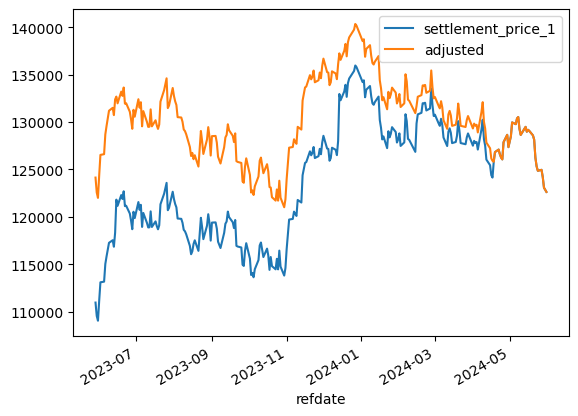

In [17]:
merged[["settlement_price_1", "adjusted"]].tail(252).plot()

In [18]:
np.log(merged[["settlement_price_1", "adjusted"]]).diff().tail(31)

,settlement_price_1,adjusted
refdate,,
2024-04-17,-0.002036,-0.002036
2024-04-18,0.013363,-0.000771
2024-04-19,0.008027,0.008027
2024-04-22,0.002119,0.002119
2024-04-23,-0.003910,-0.003910
2024-04-24,-0.002721,-0.002721
2024-04-25,-0.001562,-0.001562
2024-04-26,0.014288,0.014288
2024-04-29,0.006066,0.006066


<Axes: xlabel='refdate'>

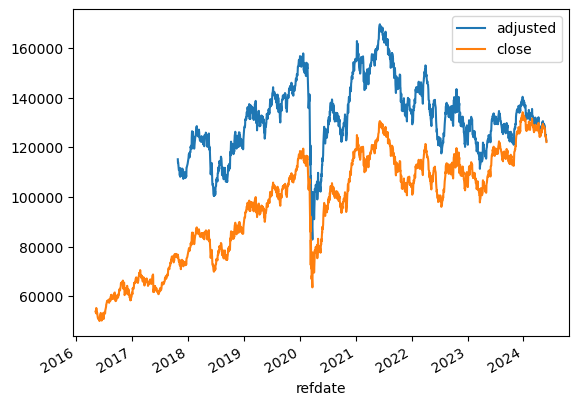

In [19]:
pd.concat([merged["adjusted"], df_ind.set_index("refdate")], axis=1).plot()

<Axes: xlabel='refdate'>

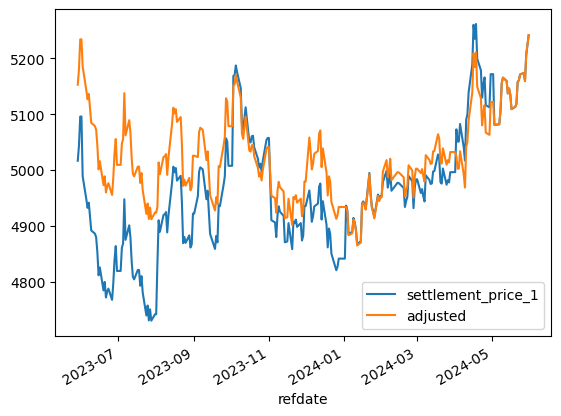

In [20]:
df_contracts = brasa.get_dataset("b3-futures-dol").to_table().to_pandas()

first = df_contracts.groupby("refdate").nth(0)
second = df_contracts.groupby("refdate").nth(1)
merged = first.merge(second, on="refdate", how="left", suffixes=("_1", "_2")).set_index("refdate")
idx = merged.index[merged["business_days_1"] == 0]
roll = merged.loc[idx, :]
roll["ratio"] = roll.settlement_price_2 / roll.settlement_price_1
merged["ratio"] = roll.ratio.iloc[::-1].cumprod().iloc[::-1]
merged["ratio"] = merged["ratio"].bfill().fillna(1)
merged["adjusted"] = merged.settlement_price_1 * merged.ratio
merged[["settlement_price_1", "adjusted"]].tail(252).plot()

<Axes: xlabel='refdate'>

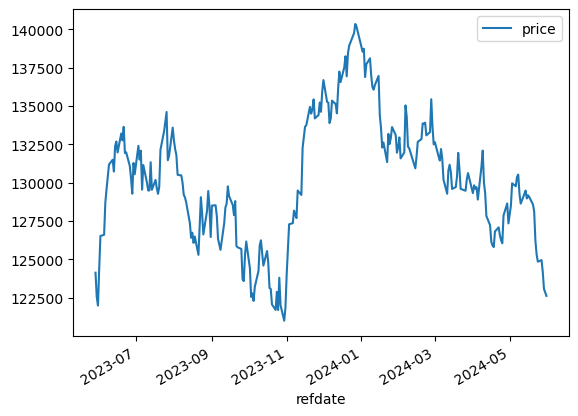

In [24]:
brasa.get_dataset("b3-futures-win-adjusted").to_table().to_pandas().tail(252).plot(x="refdate", y="price")